In [1]:
import csv
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
from torch.nn import Module
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

import math
np.random.seed(42)

In [2]:
df = pd.read_csv('data/data_lab3v03.csv', sep=',', header=None)

In [3]:
train_koeph, valid_koeph, test_koeph = 0.6, 0.3, 0.1
volume = df.size / df.columns.size
print(volume)

650.0


In [4]:
#функция деления данных
def split(data, train_koeph, valid_koeph, test_koeph):
    #отметим границы
    train_border = [0, round(len(data) * train_koeph)]
    valid_border = [round(len(data) * train_koeph), round(len(data) * (train_koeph + valid_koeph))]
    test_border = [round(len(data) * (train_koeph + valid_koeph)), len(data)]
    #делим
    train_data = (data[train_border[0]: train_border[1]])
    valid_data = (data[valid_border[0]: valid_border[1]])
    test_data = (data[test_border[0]: test_border[1]])
    return train_data, valid_data, test_data

In [5]:
def drawArray(data_class1, data_class2):
    plt.plot(data_class1[:, 0], data_class1[:, 1], 'r.',
             data_class2[:, 0], data_class2[:, 1], 'b.')
    plt.show()

400 240 120 40
250 150 75 25


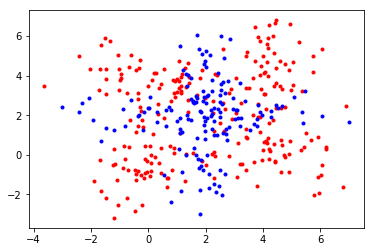

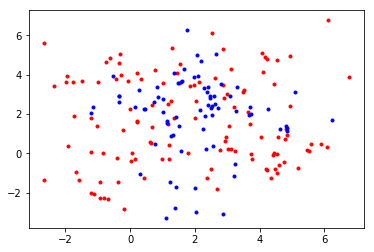

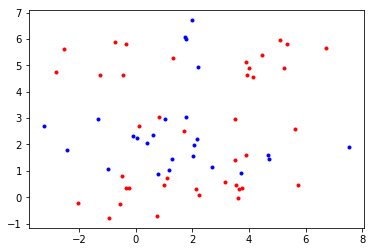

In [6]:
df.columns = ['first_arg', 'second_arg', 'class_arg']
data_class1 = df[df.class_arg == -1]
data_class2 = df[df.class_arg == 1]
#remake -1 to 0
data_class1 = data_class1.get_values()
data_class1[:,2] = np.zeros(data_class1.shape[0])
data_class1 = pd.DataFrame(data_class1)
#перемешиваем
data_class1 = data_class1.get_values()
data_class2 = data_class2.get_values()
np.random.shuffle(data_class1)
np.random.shuffle(data_class2)
data_class1 = pd.DataFrame(data_class1)
data_class2 = pd.DataFrame(data_class2)
#делим
a1, b1, c1 = split(data_class1.get_values(), train_koeph, valid_koeph, test_koeph)
a2, b2, c2 = split(data_class2.get_values(), train_koeph, valid_koeph, test_koeph)
#соединяем
train_data = np.concatenate((a1, a2))
valid_data = np.concatenate((b1, b2))
test_data = np.concatenate((c1, c2))
data_all = np.concatenate((train_data, valid_data, test_data))
#снова перемешиваем
np.random.shuffle(train_data)
np.random.shuffle(valid_data)
np.random.shuffle(test_data)
# выводим инфу
print(data_class1.shape[0], a1.shape[0], b1.shape[0], c1.shape[0])
print(data_class2.shape[0], a2.shape[0], b2.shape[0], c2.shape[0])
drawArray(a1, a2)
drawArray(b1, b2)
drawArray(c1, c2)

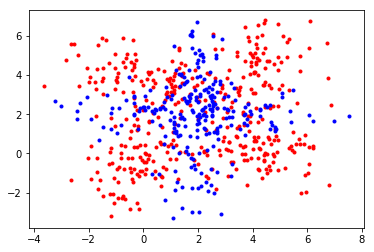

In [7]:
plt.plot(data_class1.get_values()[:, 0], data_class1.get_values()[:, 1], 'r.',
         data_class2.get_values()[:, 0], data_class2.get_values()[:, 1], 'b.')
plt.savefig('diagram_diffuse.png', bbox_inches='tight')
plt.show()

In [8]:
# Преобразование данных
# Масштабирование [-1;1]
koeph_size = 0.9
X_data_min = min(train_data[:,0])
Y_data_min = min(train_data[:,1])
X_data_max = max(train_data[:,0])
Y_data_max = max(train_data[:,1])

def normData(X_data, Y_data):
    X_data = (koeph_size * 2) * (X_data - X_data_min) / (X_data_max - X_data_min) - koeph_size
    Y_data = (koeph_size * 2) * (Y_data - Y_data_min) / (Y_data_max - Y_data_min) - koeph_size
    return X_data, Y_data
    
def backData(X_data, Y_data):
    X_data = (X_data + koeph_size) / (koeph_size * 2) * (X_data_max - X_data_min) + X_data_min
    Y_data = (Y_data + koeph_size) / (koeph_size * 2) * (Y_data_max - Y_data_min) + Y_data_min
    return X_data, Y_data

train_data[:,0], train_data[:,1] = normData(train_data[:,0], train_data[:,1])
valid_data[:,0], valid_data[:,1] = normData(valid_data[:,0], valid_data[:,1])
test_data[:,0], test_data[:,1] = normData(test_data[:,0], test_data[:,1])
data_all[:,0], data_all[:,1] = normData(data_all[:,0], data_all[:,1])

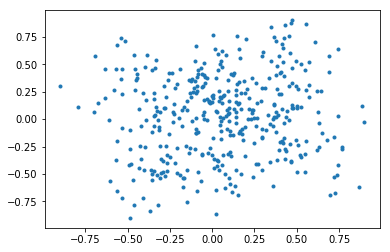

In [9]:
plt.plot(train_data[:, 0], train_data[:, 1], '.')
plt.show()

In [57]:
#Net
class Net(nn.Module):
    def __init__ (self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x;
net = Net()
print(net)
#print(net.fc1.weight.data.tolist())
#print(net.fc2.weight.data.tolist())
#print(net.fc3.weight.data.tolist())

Net (
  (fc1): Linear (2 -> 10)
  (fc2): Linear (10 -> 10)
  (fc3): Linear (10 -> 1)
)


In [58]:
def smallQuery(vDataTest):
    x = Variable(torch.Tensor(vDataTest))
    y_pred = net(x)
    y_h = y_pred.data.cpu().numpy()
    np.set_printoptions(precision=3, suppress=True)
    return y_h;

In [59]:
def showResult(data):
    a = smallQuery(np.delete(data,2,1))[:,0]
    result = copy.copy(data)
    result[:, 2] = a
    result = pd.DataFrame(result)
    result.columns = ['first_arg', 'second_arg', 'class_arg']
    r1 = result[result.class_arg > 0.5]
    r2 = result[result.class_arg <= 0.5]
    plt.plot(r1.get_values()[:,0], r1.get_values()[:,1], 'b.',
             r2.get_values()[:,0], r2.get_values()[:,1], 'r.')
    plt.savefig('result.png', bbox_inches='tight')
    plt.show()

In [60]:
def err(data, a):
    sums = 0;
    for i in range(data.shape[0]):
        sums += abs(data[i] - round(a[i]))
    return sums / data.shape[0]

In [61]:
def errors(data, a):
    tp01 = 0; tp10 = 0;
    for i in range(data.shape[0]):
        if data[i] == 0 and round(a[i]) == 1:
            tp01 += 1
        elif data[i] == 1 and round(a[i]) == 0:
            tp10 += 1
    return tp01 / data.shape[0], tp10 / data.shape[0]

In [73]:
def learn(train_data, valid_data, test_data, learning_rate, epochs):
    loss_fn = torch.nn.
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_train, loss_valid, loss_test, err_train, err_valid, err_test = [], [], [], [], [], []
    x_var = 10;

    for iter in range(epochs):
        loss_train_acc = 0
        x = Variable(torch.Tensor(np.delete(train_data, 2, 1).tolist()))
        y = Variable(torch.Tensor(train_data[:,2].tolist()))
        y_pred = net(x)   
        loss = loss_fn(y_pred, y)
        loss_train_acc = loss.data[0]    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        x_valid = Variable(torch.Tensor(np.delete(valid_data, 2, 1).tolist()))
        y_valid = Variable(torch.Tensor(valid_data[:,2].tolist()))
        x_test = Variable(torch.Tensor(np.delete(test_data, 2, 1).tolist()))
        y_test = Variable(torch.Tensor(test_data[:,2].tolist()))
        y_valid_pred = net(x_valid)
        y_test_pred = net(x_test)
        
        err_train.append(err(train_data[:,2], y_pred.data.cpu().numpy()[:,0]))
        err_valid.append(err(valid_data[:,2], y_valid_pred.data.cpu().numpy()[:,0]))
        err_test.append(err(test_data[:,2], y_test_pred.data.cpu().numpy()[:,0]))
        
        loss_train.append(loss_train_acc)
        loss_valid.append(loss_fn(y_valid_pred, y_valid).data[0])
        loss_test.append(loss_fn(y_test_pred, y_test).data[0])
        
        if loss_valid[-1] < x_var:
            x_var = loss_valid[-1]
        elif loss_valid[-1] - x_var > 0.06:
            break
            
        
        if((iter + 1) % 10000 == 0):
            print("10000 done")
        
    plt.plot(loss_train, label = "train loss")
    plt.plot(loss_valid, label = "valid loss")
    plt.plot(loss_test, label = "test loss")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    print(loss_train[-1], loss_valid[-1], loss_test[-1])
    plt.savefig('learn_loss.png', bbox_inches='tight')
    plt.show()
    
    plt.plot(loss_train, label = "train loss")
    plt.plot(loss_valid, label = "valid loss")
    plt.plot(loss_test, label = "test loss")
    plt.plot(err_train, 'blue', label = "train e")
    plt.plot(err_valid, 'red', label = "valid e")
    plt.plot(err_test, 'green', label = "test e")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    print(err_train[-1], err_valid[-1], err_test[-1])
    plt.savefig('learn_err.png', bbox_inches='tight')
    plt.show()

0.3306252956390381 0.5900055170059204 0.3389270007610321


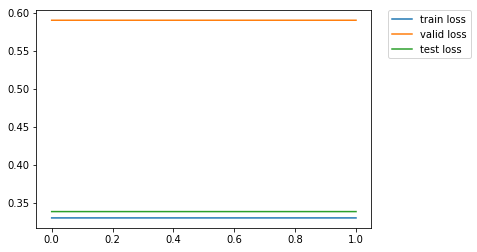

0.158974358974 0.292307692308 0.2


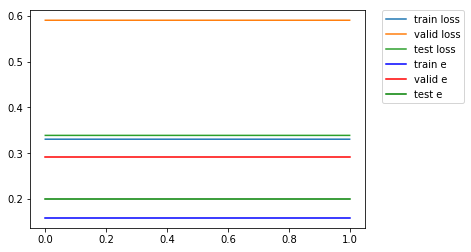

In [74]:
learn(train_data, valid_data, test_data, 0.01, 2)

In [64]:
errors(train_data[:,2], smallQuery(np.delete(train_data, 2, 1))[:,0])

(0.11282051282051282, 0.046153846153846156)

In [66]:
errors(test_data[:,2], smallQuery(np.delete(test_data, 2, 1))[:,0])

(0.1076923076923077, 0.09230769230769231)

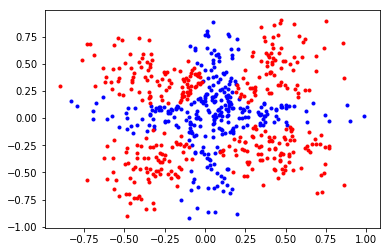

In [52]:
showResult(data_all)

In [53]:
x = np.arange(start = X_data_min, stop = X_data_max, step = 0.1)
y = np.arange(start = Y_data_min, stop = Y_data_max, step = 0.1)
data_area_ = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
data_area = np.zeros((data_area_.shape[0],3))
data_area[:,:-1] = data_area_
data_area[:,0], data_area[:,1] = normData(data_area[:,0], data_area[:,1])

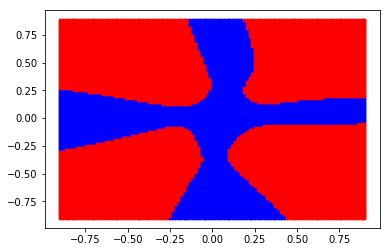

In [54]:
showResult(data_area)